In [1]:
!pip install kaggle dagshub mlflow -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 673MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [6]:
!unzip train.csv.zip
!unzip stores.csv.zip
!unzip features.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  test.csv.zip
  inflating: test.csv                


In [159]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import warnings
import dagshub
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import pickle
import joblib
import logging
import os

In [160]:
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

In [161]:
experiment_name = "Prophet_Training"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/723294fa9a3a4987bf90be420b0932f7', creation_time=1751228764096, experiment_id='1', last_update_time=1751228764096, lifecycle_stage='active', name='Prophet_Training', tags={}>

In [162]:
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet.forecaster').setLevel(logging.WARNING)
warnings.filterwarnings('ignore')

In [163]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [164]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [165]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [166]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1).rename(columns={'IsHoliday_x': 'IsHoliday'})

display(df.head())

In [167]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1).rename(columns={'IsHoliday_x': 'IsHoliday'})

# Evaluation Function

In [168]:
def WMAE(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday, 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# Preprocess

In [169]:
class ProphetDataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_prophet = X.copy()

        df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
        df_prophet = df_prophet.sort_values('ds')

        df_prophet['Temperature_lag1'] = df_prophet['Temperature'].shift(1)
        df_prophet['Fuel_Price_lag1'] = df_prophet['Fuel_Price'].shift(1)

        df_prophet = df_prophet.fillna(method='ffill').fillna(method='bfill')

        return df_prophet

# Training

In [170]:
class ProphetConfig:
    def __init__(self):
        self.params = {
            'yearly_seasonality': True,
            'weekly_seasonality': True,
            'daily_seasonality': False,
            'seasonality_mode': 'multiplicative',
            'changepoint_prior_scale': 0.05,
            'seasonality_prior_scale': 10.0,
            'holidays_prior_scale': 10.0,
            'mcmc_samples': 0,
            'interval_width': 0.80,
            'uncertainty_samples': 1000
        }

        self.regressors = {}

    def get_params(self):
        return self.params.copy()

    def get_regressors(self):
        return self.regressors.copy()

In [171]:
class ProphetWrapper(BaseEstimator):
    def __init__(self, config=None):
        self.config = config or ProphetConfig()
        self.model = None
        self.is_fitted = False

    def fit(self, X, y=None):
        prophet_params = self.config.get_params()
        regressors = self.config.get_regressors()

        import sys
        from io import StringIO

        old_stdout = sys.stdout
        sys.stdout = StringIO()

        try:
            self.model = Prophet(**prophet_params)

            for regressor_name, regressor_config in regressors.items():
                self.model.add_regressor(regressor_name, **regressor_config)

            required_cols = ['ds', 'y'] + list(regressors.keys())
            train_data = X[required_cols].dropna()

            self.model.fit(train_data)
            self.is_fitted = True
        finally:
            sys.stdout = old_stdout

        return self

    def predict(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        regressors = self.config.get_regressors()
        required_cols = ['ds'] + list(regressors.keys())

        future = X[required_cols].copy()
        future = future.dropna()

        forecast = self.model.predict(future)

        return forecast['yhat'].values

    def predict_full(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        regressors = self.config.get_regressors()
        required_cols = ['ds'] + list(regressors.keys())

        future = X[required_cols].copy()
        future = future.dropna()

        return self.model.predict(future)

    def get_params(self, deep=True):
        return {'config': self.config}

    def set_params(self, **params):
        if 'config' in params:
            self.config = params['config']
        return self

In [172]:
def create_prophet_pipeline(config=None):
    return Pipeline([
        ('preprocessor', ProphetDataPreprocessor()),
        ('prophet', ProphetWrapper(config=config))
    ])

In [173]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Store', 'Dept', 'Date'])

In [174]:
train_data = df[df['Date'] < '2012-06-01'].copy()
val_data = df[df['Date'] >= '2012-06-01'].copy()

In [175]:
def filter_sufficient_data(group):
    return len(group) >= 60

In [176]:
valid_combinations = []
for (store, dept), group in train_data.groupby(['Store', 'Dept']):
    if filter_sufficient_data(group):
        val_group = val_data[(val_data['Store'] == store) & (val_data['Dept'] == dept)]
        if len(val_group) >= 8:
            valid_combinations.append((store, dept))

print(f"Processing {len(valid_combinations)} valid store-department combinations")

Processing 2923 valid store-department combinations


Processed 100/2923 combinations
Processed 200/2923 combinations
Processed 300/2923 combinations
Processed 400/2923 combinations
Processed 500/2923 combinations
Processed 600/2923 combinations
Processed 700/2923 combinations
Processed 800/2923 combinations
Processed 900/2923 combinations
Processed 1000/2923 combinations
Processed 1100/2923 combinations
Processed 1200/2923 combinations
Processed 1300/2923 combinations
Processed 1400/2923 combinations
Processed 1500/2923 combinations
Processed 1600/2923 combinations
Processed 1700/2923 combinations
Processed 1800/2923 combinations
Processed 1900/2923 combinations
Processed 2000/2923 combinations
Processed 2100/2923 combinations
Processed 2200/2923 combinations
Processed 2300/2923 combinations
Processed 2400/2923 combinations
Processed 2500/2923 combinations
Processed 2600/2923 combinations
Processed 2700/2923 combinations
Processed 2800/2923 combinations
Processed 2900/2923 combinations


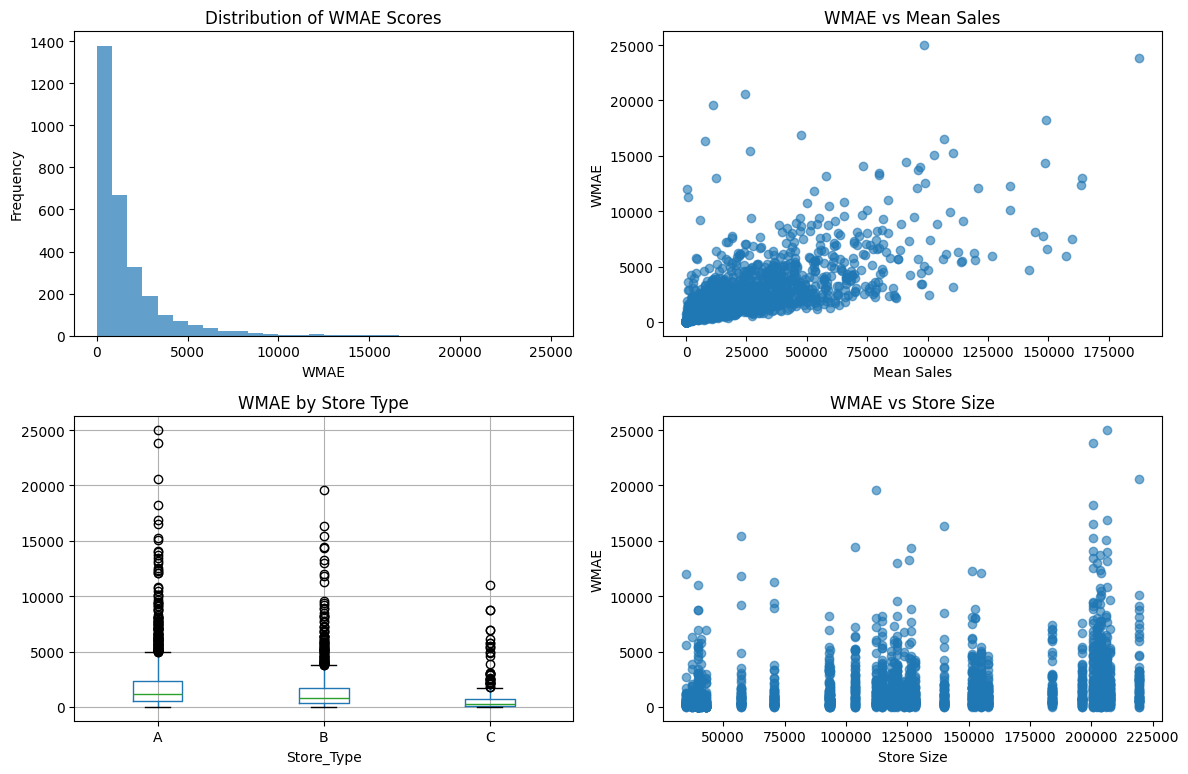


Best model: Store 33, Dept 12 (WMAE: 6.87)


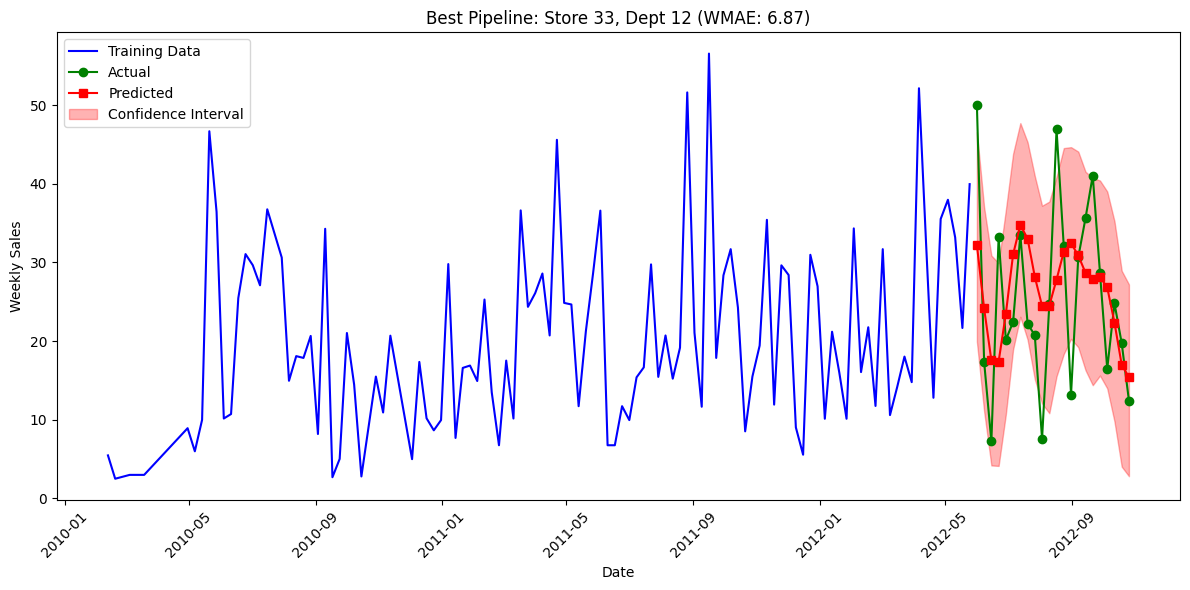


Processed 2923 store-department combinations
Overall WMAE statistics:
count     2923.000000
mean      1628.506450
std       2189.566485
min          6.872473
25%        388.771442
50%        912.353999
75%       1951.763025
max      24985.610064
Name: WMAE, dtype: float64

Top 10 best performing combinations:
      Store  Dept      WMAE Store_Type  Mean_Sales
2192     33    12  6.872473          A   20.160550
2018     30    52  7.033639          C   20.224215
932      14    51  7.203761          A   38.778750
187       3    59  7.481098          B  277.776667
455       7    59  7.634214          B   92.044563
2482     38    52  7.642650          C   22.026777
2824     44    23  7.747812          C   19.711842
1943     29    19  8.415325          B   41.064286
2739     42    52  8.572294          C   34.787934
2833     44    52  8.902518          C   27.924050

Performance by Store Type:
                   mean       median  count
Store_Type                                 
A          

In [177]:
with mlflow.start_run(run_name="prophet_pipeline_with_temp_regressor=0.01"):
    config = ProphetConfig()
    pipeline = create_prophet_pipeline(config)

    prophet_params = config.get_params()
    regressors = config.get_regressors()

    for param_name, param_value in prophet_params.items():
        mlflow.log_param(f"prophet_{param_name}", param_value)

    for regressor_name, regressor_config in regressors.items():
        for config_key, config_value in regressor_config.items():
            mlflow.log_param(f"regressor_{regressor_name}_{config_key}", config_value)

    mlflow.log_param("model_type", "Prophet_Pipeline")
    mlflow.log_param("total_combinations", len(valid_combinations))
    mlflow.log_param("train_end_date", "2012-06-01")
    mlflow.log_param("min_train_size", 60)
    mlflow.log_param("min_val_size", 8)

    batch_size = 50
    results = []
    processed = 0
    total = len(valid_combinations)

    best_wmae = float('inf')
    best_pipeline = None
    best_forecast = None
    best_combination = None
    best_train_data = None
    best_val_data = None

    for i in range(0, len(valid_combinations), batch_size):
        batch_combinations = valid_combinations[i:i+batch_size]

        for store, dept in batch_combinations:
            try:
                train_group = train_data[(train_data['Store'] == store) & (train_data['Dept'] == dept)]
                val_group = val_data[(val_data['Store'] == store) & (val_data['Dept'] == dept)]

                if len(train_group) < 30 or len(val_group) < 4:
                    continue

                current_pipeline = create_prophet_pipeline(config)
                current_pipeline.fit(train_group)

                predictions = current_pipeline.predict(val_group)

                wmae = WMAE(
                    val_group['Weekly_Sales'].values,
                    predictions,
                    val_group['IsHoliday'].values
                )

                if wmae < best_wmae:
                    best_wmae = wmae
                    best_pipeline = current_pipeline
                    best_combination = (store, dept)
                    best_train_data = train_group.copy()
                    best_val_data = val_group.copy()

                    preprocessed_val = current_pipeline['preprocessor'].transform(val_group)
                    best_forecast = current_pipeline['prophet'].predict_full(preprocessed_val)

                results.append({
                    'Store': store,
                    'Dept': dept,
                    'WMAE': wmae,
                    'Train_Size': len(train_group),
                    'Val_Size': len(val_group),
                    'Mean_Sales': train_group['Weekly_Sales'].mean(),
                    'Store_Type': train_group['Type'].iloc[0],
                    'Store_Size': train_group['Size'].iloc[0]
                })

                processed += 1
                if processed % 100 == 0:
                    print(f"Processed {processed}/{total} combinations")
                    current_results = pd.DataFrame(results)
                    mlflow.log_metric("avg_wmae_so_far", current_results['WMAE'].mean(), step=processed)
                    mlflow.log_metric("best_wmae_so_far", current_results['WMAE'].min(), step=processed)

            except Exception as e:
                print(f"Error processing Store {store}, Dept {dept}: {str(e)}")
                continue

    results_df = pd.DataFrame(results)

    if len(results_df) > 0:
        mlflow.log_metric("final_avg_wmae", results_df['WMAE'].mean())
        mlflow.log_metric("final_median_wmae", results_df['WMAE'].median())
        mlflow.log_metric("final_best_wmae", results_df['WMAE'].min())
        mlflow.log_metric("final_worst_wmae", results_df['WMAE'].max())
        mlflow.log_metric("total_successful_models", len(results_df))

        store_type_performance = results_df.groupby('Store_Type')['WMAE'].agg(['mean', 'median', 'count'])
        for store_type in store_type_performance.index:
            mlflow.log_metric(f"wmae_mean_store_type_{store_type}",
                            store_type_performance.loc[store_type, 'mean'])
            mlflow.log_metric(f"wmae_median_store_type_{store_type}",
                            store_type_performance.loc[store_type, 'median'])
            mlflow.log_metric(f"count_store_type_{store_type}",
                            store_type_performance.loc[store_type, 'count'])

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.hist(results_df['WMAE'], bins=30, alpha=0.7)
        plt.title('Distribution of WMAE Scores')
        plt.xlabel('WMAE')
        plt.ylabel('Frequency')

        plt.subplot(2, 2, 2)
        plt.scatter(results_df['Mean_Sales'], results_df['WMAE'], alpha=0.6)
        plt.xlabel('Mean Sales')
        plt.ylabel('WMAE')
        plt.title('WMAE vs Mean Sales')

        plt.subplot(2, 2, 3)
        results_df.boxplot(column='WMAE', by='Store_Type', ax=plt.gca())
        plt.title('WMAE by Store Type')
        plt.suptitle('')

        plt.subplot(2, 2, 4)
        plt.scatter(results_df['Store_Size'], results_df['WMAE'], alpha=0.6)
        plt.xlabel('Store Size')
        plt.ylabel('WMAE')
        plt.title('WMAE vs Store Size')

        plt.tight_layout()
        plt.savefig('prophet_pipeline_analysis.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('prophet_pipeline_analysis.png')
        plt.show()

        if best_pipeline is not None:
            print(f"\nBest model: Store {best_combination[0]}, Dept {best_combination[1]} (WMAE: {best_wmae:.2f})")

            mlflow.log_param("best_store", best_combination[0])
            mlflow.log_param("best_dept", best_combination[1])
            mlflow.log_metric("best_model_wmae", best_wmae)

            joblib.dump(best_pipeline, 'best_prophet_pipeline.pkl')
            mlflow.log_artifact('best_prophet_pipeline.pkl')

            plt.figure(figsize=(12, 6))
            plt.plot(best_train_data['Date'], best_train_data['Weekly_Sales'],
                    label='Training Data', color='blue')
            plt.plot(best_val_data['Date'], best_val_data['Weekly_Sales'],
                    label='Actual', color='green', marker='o')
            plt.plot(best_val_data['Date'], best_forecast['yhat'],
                    label='Predicted', color='red', marker='s')
            plt.fill_between(best_val_data['Date'], best_forecast['yhat_lower'],
                           best_forecast['yhat_upper'],
                           alpha=0.3, color='red', label='Confidence Interval')
            plt.title(f'Best Pipeline: Store {best_combination[0]}, Dept {best_combination[1]} (WMAE: {best_wmae:.2f})')
            plt.xlabel('Date')
            plt.ylabel('Weekly Sales')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('best_pipeline_forecast.png', dpi=300, bbox_inches='tight')
            mlflow.log_artifact('best_pipeline_forecast.png')
            plt.show()

        print(f"\nProcessed {len(results_df)} store-department combinations")
        print(f"Overall WMAE statistics:")
        print(results_df['WMAE'].describe())

        print(f"\nTop 10 best performing combinations:")
        print(results_df.nsmallest(10, 'WMAE')[['Store', 'Dept', 'WMAE', 'Store_Type', 'Mean_Sales']])

        print(f"\nPerformance by Store Type:")
        print(results_df.groupby('Store_Type')['WMAE'].agg(['mean', 'median', 'count']))